# Laboratory #3_2 : Image Classification using Bag of Visual Words

At the end of this laboratory, you would get familiarized with

*   Creating Bag of Visual Words
    *   Feature Extraction
    *   Codebook construction
    *   Classification

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import os
import numpy as np

from skimage.feature import ORB
from skimage.color import rgb2gray
from skimage.io import imread
from scipy.cluster.vq import vq

from matplotlib import pyplot as plt

## Loading dataset

We will use 3 categories from Caltech 101 objects dataset for this experiment. Upload the dataset to the drive and mount it.

In [3]:
# modify the dataset variable with the path from your drive

dataset_path = r'CV/Labs/P07_1_bag_of_words/Caltech_101_subset'

In [4]:
categories = ['butterfly', 'kangaroo', 'dalmatian']
ncl = len(categories) * 10

*   Create a list of file and the corresponding labels

In [5]:
# solution
data = []
for category in os.listdir(dataset_path):
    for file in os.listdir(os.path.join(dataset_path, category)):
        img = imread(os.path.join(dataset_path, category, file))
        if len(img.shape) == 3:
            img = rgb2gray(img, channel_axis=2)
        num_cat = categories.index(category)
        data.append([img, num_cat])

print(data[0][0].shape)
print(data[0][1])

(196, 300)
2


In [6]:
print('Total number of images:', len(data))

Total number of images: 244


*   Create a train / test split where the test is 10% of the total data

In [7]:
# solution

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split([x[0] for x in data], 
                                                    [x[1] for x in data], 
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    stratify=[x[1] for x in data])

In [8]:
print('Train set:', len(x_train))
print('Test set:', len(x_test))

Train set: 219
Test set: 25


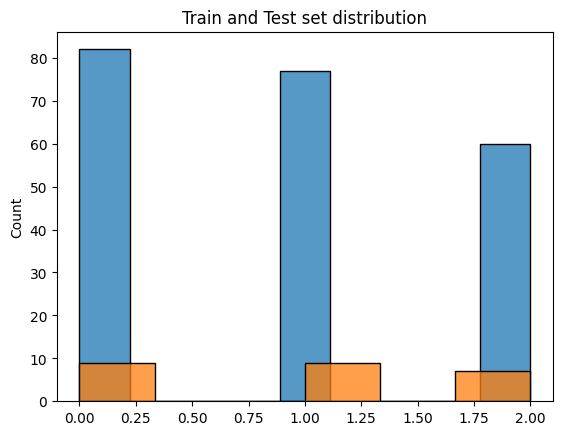

In [9]:
import seaborn as sns
sns.histplot(y_train)
sns.histplot(y_test)
plt.title('Train and Test set distribution')
plt.show()

*   How do you select the train/test split?

**Solution**

As it can be infered from the previous plot, train and test are selected so that test set has the same distribution over the classes as the train set, so that the difference betweeen the train and test set is not due to the difference in the distribution of the classes but to our model and parameters selection_.

## Feature Extraction using ORB

The first step is to extract descriptors for each image in our dataset. We will use ORB to extract descriptors.

*   Create ORB detector with 64 keypoints.


In [10]:
# solution

descriptor_extractor = ORB(n_keypoints=64)

*   Extract ORB descriptors from all the images in the train set.


In [11]:
# solution

def extract_features(img, descriptor_extractor):
    descriptor_extractor.detect_and_extract(img)
    return descriptor_extractor.keypoints, descriptor_extractor.descriptors

ls_desc = []
for img in x_train:
    _, desc = extract_features(img, descriptor_extractor)
    ls_desc.append(desc)

*   What is the size of the feature descriptors? What does each dimension represent in the feature descriptors?

In [12]:
# solution

print("Dimensions of feature descriptors: ", set([x.shape for x in ls_desc]))


Dimensions of feature descriptors:  {(64, 256)}


**Solution**

The size of the feature descriptors generated by ORB is fixed and typically 256 bits (32 bytes) per descriptor. Each dimension of the feature descriptor represents a binary value (0 or 1) generated by the BRIEF (Binary Robust Independent Elementary Features) algorithm, which is used by ORB for descriptor computation.

To break it down:

- Size of Feature Descriptor: 256 bits (32 bytes)

- Each Dimension: Represents a binary value (0 or 1) indicating the result of a binary test applied during the BRIEF algorithm.

The result of the BRIEF algorithm is this binary vector, which serves as a compact representation of the local image characteristics around a keypoint. This binary nature makes BRIEF descriptors computationally efficient and suitable for applications where speed and memory are critical, such as real-time computer vision tasks. The binary descriptors can be used for matching keypoints between images by comparing the Hamming distance between their binary vectors.

## Codebook Construction

Codewords are nothing but vector representation of similar patches. This codeword produces a codebook similar to a word dictionary. We will create the codebook using K-Means algorithm

*   Create a codebook using K-Means with k=number_of_classes*10
*   Hint: Use sklearn.cluster.MiniBatchKMeans for K-Means

In [13]:
# Firs of all let's concatenate all the descriptors in a single array
X_desc = np.concatenate(ls_desc)
print("The length should be ", len(ls_desc), " images x", 64, " features:", len(ls_desc) * 64)
print("Shape of the concatenated array: ", X_desc.shape)

The length should be  219  images x 64  features: 14016
Shape of the concatenated array:  (14016, 256)


In [14]:
# solution
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=ncl, random_state=42)
kmeans.fit(X_desc)

/home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


MiniBatchKMeans(n_clusters=30, random_state=42)

*   Create a histogram using the cluster centers for each image descriptor.
    *   Remember the histogram would be of size *n_images x n_clusters*.

In [15]:
centroid_vectors = [kmeans.predict(img_descs) for img_descs in ls_desc]

hist_train = np.zeros((len(centroid_vectors), ncl), "float64")

for i, sample in enumerate(centroid_vectors):
  hist_train[i, :] = np.histogram(sample, bins=ncl, range=(0, ncl-1), density=False) [0]

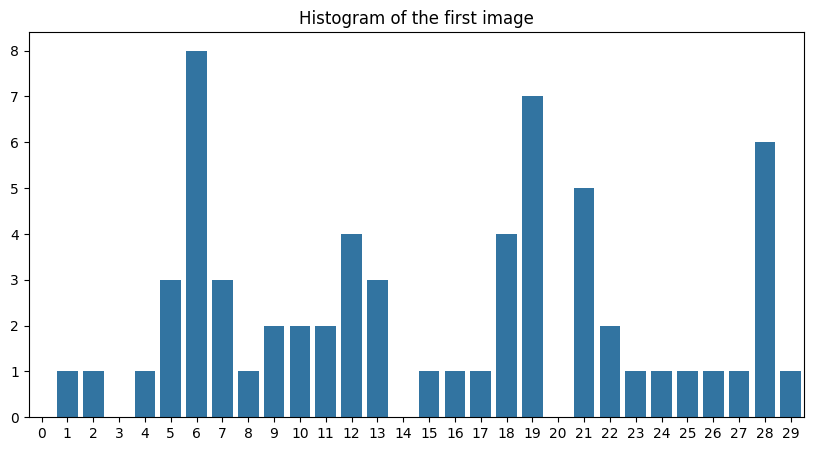

In [18]:
# barplot of hist_train
plt.figure(figsize=(10, 5))
sns.barplot(x=list(range(ncl)), y=hist_train[0])
plt.title('Histogram of the first image')
plt.show()

To test it works, every histogram should sum to 64.

In [19]:
hist_train.sum(axis=1)

array([64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64


# Creating Classification Model

*   The next step is to create a classification model. We will use a C-Support Vector Classification for creating the model.



In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

*   Use GridSearchCV to find the optimal value of C and Gamma.

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
sc = StandardScaler()
X_train_sc = sc.fit_transform(hist_train)

parameters = {'C':np.logspace(-3, 4, 18), 'gamma':np.logspace(-3, 2, 18)}

model = SVC(kernel='rbf')
gs = GridSearchCV(model, parameters,
                   cv=5, n_jobs=-1, scoring='accuracy', verbose=1)
gs.fit(X_train_sc, y_train)

best_model = gs.best_estimator_

print('Best score:', gs.best_score_)
print('Best Params:', gs.best_params_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best score: 0.5665961945031712
Best Params: {'C': 0.7626985859023444, 'gamma': 0.007626985859023444}


# Testing the Classification Model

*   Extract descriptors using ORB for the test split
*   Use the previously trained k-means to generate the histogram
*   Use the classifier to predict the label


In [22]:
# solution

ls_test_desc = []
for img in x_test:
    _, desc = extract_features(img, descriptor_extractor)
    ls_test_desc.append(desc)

test_centroid_vectors = [kmeans.predict(img_descs) for img_descs in ls_test_desc]

hist_test = np.zeros((len(test_centroid_vectors), ncl), "float64")

for i, sample in enumerate(test_centroid_vectors):
  hist_test[i, :] = np.histogram(sample, bins=ncl, range=(0, ncl-1), density=False) [0]

In [23]:
hist_test.sum(axis=1)

array([64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.])

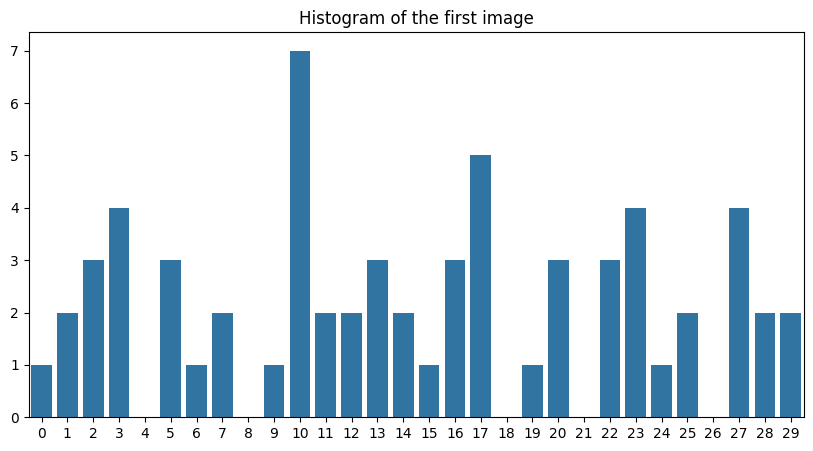

In [24]:
# Plot first image histogram
plt.figure(figsize=(10, 5))
sns.barplot(x=list(range(ncl)), y=hist_test[0])
plt.title('Histogram of the first image')
plt.show()

*   Calculate the accuracy score for the classification model

In [25]:
# solution

print('Accuracy on test set:', accuracy_score(y_test, best_model.predict(sc.transform(hist_test))))

Accuracy on test set: 0.56


*   Generate the confusion matrix for the classification model

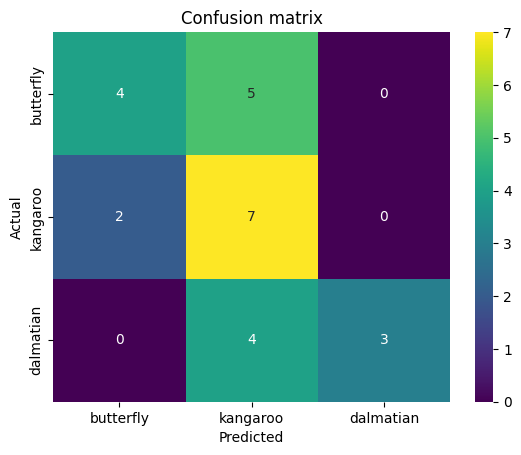

In [26]:
# solution

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_model.predict(sc.transform(hist_test)))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=categories, yticklabels=categories)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

*   Why do we use Clustering to create the codebook? 
*   What are the other techniques that can be used to create the codebook?

**Solution**

**Why use Clustering to create the codebook?**

Using clustering, such as K-Means, to create a codebook is a common technique in computer vision and image processing for several reasons:

1. **Compression of Information:** Clustering helps compress the information in the feature space. Instead of using all individual feature descriptors, a codebook represents a set of cluster centers, reducing the dimensionality of the data.

2. **Quantization:** The cluster centers serve as prototypes or codewords that capture the variability and patterns in the data. Assigning each feature descriptor to its nearest cluster effectively quantizes the descriptor, providing a compact representation.

3. **Discriminative Features:** Clustering tends to group similar features together. The resulting clusters (codebook entries) are representative of different patterns or structures in the data, making them potentially more discriminative for various tasks like image recognition.

4. **Memory and Computational Efficiency:** Working with a codebook is more memory-efficient than storing all individual descriptors. Additionally, during processing, comparing against a limited set of codewords is computationally less expensive than comparing against all original descriptors.

5. **Robustness to Noise:** Clustering helps in reducing the impact of noise or outliers by grouping similar features together. Outliers may be assigned to the nearest cluster, making the representation more robust.

**Other Techniques for Codebook Creation:**

1. **Principal Component Analysis (PCA):** PCA can be used to reduce the dimensionality of feature descriptors. The principal components can serve as a reduced set of features, acting as a codebook.

2. **Vector Quantization (VQ):** Similar to clustering, VQ involves partitioning the feature space into regions and representing each region by a vector (code vector). This is commonly used in image compression and can be adapted for codebook creation.

3. **Sparse Coding:** In sparse coding, each feature descriptor is represented as a sparse linear combination of dictionary elements. The dictionary serves a similar purpose to a codebook.

4. **Neural Network Embeddings:** Neural networks, particularly autoencoders and embeddings, can be used to learn a lower-dimensional representation of feature descriptors, which can serve as a codebook.

The choice of technique depends on the specific application, the characteristics of the data, and the computational constraints. Clustering is popular due to its simplicity, interpretability, and effectiveness in capturing patterns in the data.

# Increased Feature Dimensions

*   Repeat the classification using features of 256 ORB keypoints.

In [29]:
# Create feature extractor
descriptor_extractor = ORB(n_keypoints=256)


def extract_features(img, descriptor_extractor):
    descriptor_extractor.detect_and_extract(img)
    return descriptor_extractor.keypoints, descriptor_extractor.descriptors

# Apply feature extractor to all images
ls_desc = []
for img in x_train:
    _, desc = extract_features(img, descriptor_extractor)
    ls_desc.append(desc)

# Firs of all let's concatenate all the descriptors in a single array
X_desc = np.concatenate(ls_desc)
print("The length should be ", len(ls_desc), " images x", 256, " features:", len(ls_desc) * 256)
print("Shape of the concatenated array: ", X_desc.shape)

The length should be  219  images x 256  features: 56064
Shape of the concatenated array:  (56039, 256)


In [31]:
kmeans = MiniBatchKMeans(n_clusters=ncl, random_state=42, n_init=100, max_iter=1000)
kmeans.fit(X_desc)

centroid_vectors = [kmeans.predict(img_descs) for img_descs in ls_desc]
print('Length of centroid_vectors:', len(centroid_vectors))

Length of centroid_vectors: 219


In [32]:
for i, sample in enumerate(centroid_vectors):
  hist_train[i, :] = np.histogram(sample, bins=ncl, range=(0, ncl-1), density=False) [0]

hist_train.sum(axis=1)

array([256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
       256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
       256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
       256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
       256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 231.,
       256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
       256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
       256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
       256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
       256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
       256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
       256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
       256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
       256., 256., 256., 256., 256., 256., 256., 25

In [33]:
# Train the classifier
sc = StandardScaler()
X_train_sc = sc.fit_transform(hist_train)

parameters = {'C':np.logspace(-3, 4, 18), 'gamma':np.logspace(-3, 2, 18)}

model = SVC(kernel='rbf')
gs = GridSearchCV(model, parameters,
                   cv=5, n_jobs=-1, scoring='accuracy', verbose=1)

gs.fit(X_train_sc, y_train)

best_model = gs.best_estimator_

print('Best score:', gs.best_score_)
print('Best Params:', gs.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best score: 0.6345665961945031
Best Params: {'C': 1.9684194472866112, 'gamma': 0.001}


In [34]:
# Create test set histograms
ls_test_desc = []
for img in x_test:
    _, desc = extract_features(img, descriptor_extractor)
    ls_test_desc.append(desc)

test_centroid_vectors = [kmeans.predict(img_descs) for img_descs in ls_test_desc]

hist_test = np.zeros((len(test_centroid_vectors), ncl), "float64")

for i, sample in enumerate(test_centroid_vectors):
  hist_test[i, :] = np.histogram(sample, bins=ncl, range=(0, ncl-1), density=False) [0]

hist_test.sum(axis=1)

array([256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
       256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
       256., 256., 256.])

Accuracy on test set: 0.64


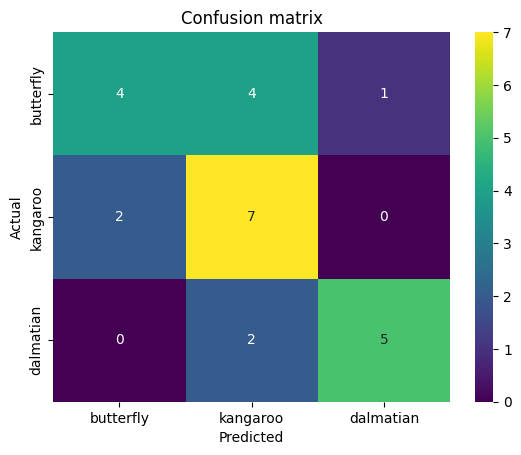

In [35]:
# solution

print('Accuracy on test set:', accuracy_score(y_test, best_model.predict(sc.transform(hist_test))))

y_pred = best_model.predict(sc.transform(hist_test))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=categories, 
            yticklabels=categories)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

*   What is the difference in classifier performance between using 64 keypoints and 256 keypoints?

**Solution**

Using more keypoints improves the performance of the classifier. This is because the feature descriptors are more discriminative and capture more information about the image. However, this comes at the cost of increased memory and computational requirements.

*   Will further adding more keypoints increase the performance of the algorithm?

**Solution**

Not necessarily, due to the following reasons:

1. **Diminishing Returns:** As the number of keypoints increases, the performance improvement may not be significant. This is because the additional keypoints may not be very discriminative or may not capture much additional information.
2. **Overfitting:** Using too many keypoints may lead to overfitting, where the model performs well on the training data but does not generalize well to unseen data. This is because the model may learn to recognize specific keypoints in the training data, which may not be present in the test data.
3. **Computational and Memory Requirements:** Using more keypoints increases the computational and memory requirements, which may not be feasible in real-world applications.
4. **Curse of Dimensionality:** As the dimensionality of the feature space increases, the data becomes more sparse, and the distance between points becomes less meaningful. This can lead to poor performance of the classifier.
5. **Noise:** Using more keypoints may increase the impact of noise or outliers in the data, leading to poor performance.